In [1]:
import datetime
import os
import time
import numpy as np

import presets
import torch
import torch.utils.data
import torchvision
import utils
from torch import nn
import json
from PIL import Image
from PIL import ImageDraw

from dataset import FishyscapesCroppedDataset, RailSem19CroppedDatasetLikeFishyrails
from autoencoder_param import AeSegParam01, AeSegParam02
from torchgeometry.losses.ssim import SSIM
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from patch_seg_networks import PatchSegModel03, PatchSegModelLight
from torchvision.transforms import functional as F

In [2]:
def evaluate_students(teacher_model, student1_model, student2_model, student3_model, data_loader, g_act, obstacle_threshold, patch_size, device, idx_list, vis_path=None, mean=None, std=None, overall_max=1):
    teacher_model.eval()
    student1_model.eval()
    student2_model.eval()
    student3_model.eval()

    metric_logger = utils.MetricLogger(delimiter="  ")

    if vis_path:
        utils.mkdir(vis_path)
    header = "Test:"

    storage = list()

    # Compute max if necessary:
    print(f"Overall Max: {overall_max}")


    with torch.no_grad():
        for idx, (image_fishy, target_fishy, image_orig, target_orig) in enumerate(metric_logger.log_every(data_loader, 100, header)):
            
            if idx not in idx_list:
                continue
            
            print(f"Image {idx} ...")
            idx_results = dict()
                
            # Go over fishy and orig:
            for mode in ["fishy", "orig"]:
                # Prepare everything
                if mode == "fishy":
                    image, target_seg = image_fishy.to(device), target_fishy.to(device)
                elif mode == "orig":
                    image, target_seg = image_orig.to(device), target_orig.to(device)
                target_seg_orig = target_orig.clone().to(device)

                # Mask for evaluation (discard background)
                evaluation_mask = target_seg_orig == 1
                target_seg[torch.logical_not(evaluation_mask)] = 0
                evaluation_mask = evaluation_mask.squeeze()

                # Visualize original image
                if g_act == "tanh":
                    image_target_ae, _ = presets.denormalize_tanh(image, image)  # (-1, 1)
                    image_vis_pil, _ = presets.re_convert_tanh(image_target_ae, image_target_ae)
                else:
                    image_target_ae, _ = presets.denormalize(image, image)  # (0, 1)
                    image_vis_pil, _ = presets.re_convert(image_target_ae, image_target_ae)
                image_vis = np.asarray(image_vis_pil)
                idx_results[f"image_{mode}"] = image_vis

                image_ae_vis = np.ones_like(image_vis)*255 # dummy
                idx_results[f"ae_{mode}"] = image_ae_vis
        

                # Prepare input for PatchSeg model
                input_seg = image

                # Inference
                with torch.no_grad():
                    outputs_teacher = teacher(input_seg)["descriptor"]
                    normalized_teacher = F.normalize(outputs_teacher, mean=mean["teacher"], std=std["teacher"]).clone().detach()
                    outputs_student1 = student1(input_seg)["descriptor"]
                    outputs_student2 = student2(input_seg)["descriptor"]
                    outputs_student3 = student3(input_seg)["descriptor"]
                    output_e_students = 1/3 * (outputs_student1 + outputs_student2 + outputs_student3)
                    output_e = torch.squeeze(torch.square(normalized_teacher - output_e_students))
                    output_e = torch.sum(output_e, dim=0)
                    output_e_normalized = torch.abs((output_e - mean["e"]) / std["e"])
                    output_v_mean = torch.sum(torch.squeeze(torch.square(output_e_students)), dim=0)
                    output_v_student1 = torch.sum(torch.squeeze(torch.square(outputs_student1)), dim=0)
                    output_v_student2 = torch.sum(torch.squeeze(torch.square(outputs_student2)), dim=0)
                    output_v_student3 = torch.sum(torch.squeeze(torch.square(outputs_student3)), dim=0)
                    output_v = 1/3 * (output_v_student1 + output_v_student2 + output_v_student3) - output_v_mean
                    output_v_normalized = torch.abs((output_v - mean["v"]) / std["v"])
                    output_seg = output_e_normalized + output_v_normalized

                # Make sure segmentation outputs are in range (0, 1):
                output_seg[output_seg > overall_max] = overall_max
                output_seg = output_seg / overall_max
                # Check if segmentation outputs are in range (0, 1):
                if torch.max(output_seg) > 1 or torch.min(output_seg) < 0:
                    print("ERROR: Output segmentation out of range!")
                    return

                # Compute whether an obstacle can be found in seg output based on patch density:
                kernel = torch.tensor(np.ones((patch_size, patch_size))* 1/(patch_size*patch_size)).view(1, 1, patch_size, patch_size).type(torch.FloatTensor)
                output_seg_masked = output_seg.clone()
                output_seg_masked[torch.logical_not(evaluation_mask)] = 0
                patch_density = torch.nn.functional.conv2d(output_seg_masked.unsqueeze(0).unsqueeze(1), kernel, padding='same')
                max_patch_density = torch.max(patch_density)
                patch_density[patch_density <= obstacle_threshold] = 0
                patch_density.squeeze()
                if max_patch_density > obstacle_threshold:
                    found_obstacle = 1
                    # Compute centroid based on patch density
                    x = torch.linspace(0, 223, steps=224).unsqueeze(0)
                    x = x.repeat(224, 1)
                    y = torch.linspace(0, 223, steps=224).unsqueeze(1)
                    y = y.repeat(1, 224)
                    centroid_x = int(
                        torch.floor(torch.sum(patch_density * x) / torch.sum(patch_density)).type(torch.LongTensor))
                    centroid_y = int(
                        torch.floor(torch.sum(patch_density * y) / torch.sum(patch_density)).type(torch.LongTensor))
                else:
                    found_obstacle = 0


                # Compute whether an obstacle can be found in groundtruth:
                target_seg_masked = target_seg.clone().type(torch.FloatTensor)
                target_seg_masked[target_seg == 1] = 0
                target_seg_masked[target_seg == 2] = 1
                patch_density_target = torch.nn.functional.conv2d(target_seg_masked, kernel, padding='same')
                max_patch_density_target = torch.max(patch_density_target)
                if max_patch_density_target > 0.3:
                    has_obstacle = 1
                    # Get bounding box
                    target_seg_masked_pil = presets.torch_mask_to_pil(target_seg_masked)
                    l_bb, u_bb, r_bb, d_bb = target_seg_masked_pil.getbbox()
                else:
                    has_obstacle = 0

                # Check whether found obstacle was correct
                if found_obstacle == 1 and has_obstacle == 1 and l_bb < centroid_x < r_bb and u_bb < centroid_y < d_bb:
                    found_correct = True
                else:
                    found_correct = False

                # Visualize Patch Density
                patch_density[patch_density > 0] = 1
                patch_density_vis_gray = patch_density * 255
                patch_density_vis_gray = presets.torch_mask_to_pil(patch_density_vis_gray)
                patch_density_vis = Image.new("RGB", patch_density_vis_gray.size)
                patch_density_vis.paste(patch_density_vis_gray)
                patch_density_vis = Image.blend(patch_density_vis, image_vis_pil, 0.5)
                draw = ImageDraw.Draw(patch_density_vis)
                if found_obstacle == 1:
                    if found_correct == 1:
                        draw.ellipse((centroid_x-5 , centroid_y-5, centroid_x+5 , centroid_y+5), fill="green")
                    else:
                        draw.ellipse((centroid_x - 5, centroid_y - 5, centroid_x + 5, centroid_y + 5), fill="red")
                if has_obstacle == 1:
                    if found_correct == 1:
                        draw.rectangle((l_bb, u_bb, r_bb, d_bb), outline="green", width=5)
                    else:
                        draw.rectangle((l_bb, u_bb, r_bb, d_bb), outline="red", width=5)
                patch_density_vis = np.asarray(patch_density_vis)
                idx_results[f"pred_detect_{mode}"] = patch_density_vis
                
                # Visualize Target Patch Density
                patch_density_target[patch_density_target < 0.3] = 0
                patch_density_target[patch_density_target > 0] = 1
                patch_density_target = patch_density_target.squeeze()
                patch_density_target_vis_gray = patch_density_target * 255
                patch_density_target_vis_gray = presets.torch_mask_to_pil(patch_density_target_vis_gray)
                patch_density_target_vis = Image.new("RGB", patch_density_target_vis_gray.size)
                patch_density_target_vis.paste(patch_density_target_vis_gray)
                patch_density_target_vis = Image.blend(patch_density_target_vis, image_vis_pil, 0.5)
                draw = ImageDraw.Draw(patch_density_target_vis)
                if has_obstacle == 1:
                    draw.rectangle((l_bb, u_bb, r_bb, d_bb), outline="blue", width=5)
                patch_density_target_vis = np.asarray(patch_density_target_vis)
                idx_results[f"target_detect_{mode}"] = patch_density_target_vis

                # Visualized output seg masked
                output_seg_masked_vis_gray = output_seg
                output_seg_masked_vis_gray[torch.logical_not(evaluation_mask)] = 0.5
                output_seg_masked_vis_gray = output_seg_masked_vis_gray * 255
                output_seg_masked_vis_gray = presets.torch_mask_to_pil(output_seg_masked_vis_gray)
                output_seg_masked_vis = Image.new("RGB", output_seg_masked_vis_gray.size)
                output_seg_masked_vis.paste(output_seg_masked_vis_gray)
                draw = ImageDraw.Draw(output_seg_masked_vis)
                output_seg_masked_vis = np.asarray(output_seg_masked_vis)
                idx_results[f"pred_seg_{mode}"] = output_seg_masked_vis

                # Visualize target segmentation
                target_obs_seg_vis_gray = torch.zeros_like(target_seg)
                target_obs_seg_vis_gray[target_seg == 2] = 255 # obstacle white
                target_obs_seg_vis_gray[target_seg == 0] = 127 # background gray
                target_obs_seg_vis_gray = presets.torch_mask_to_pil(target_obs_seg_vis_gray)
                target_obs_seg_vis = Image.new("RGB", target_obs_seg_vis_gray.size)
                target_obs_seg_vis.paste(target_obs_seg_vis_gray)
                draw = ImageDraw.Draw(target_obs_seg_vis)
                target_obs_seg_vis = np.asarray(target_obs_seg_vis)
                idx_results[f"target_seg_{mode}"] = target_obs_seg_vis
            storage.append(idx_results)

    return storage

In [3]:
def evaluate(ae_model, ae_model_name, model, model_name, data_loader, g_act, obstacle_threshold, patch_size, device, idx_list, vis_path=None, mean=None, std=None):
    if ae_model:
        ae_model.eval()
    if model:
        model.eval()

    metric_logger = utils.MetricLogger(delimiter="  ")

    if vis_path:
        utils.mkdir(vis_path)
    header = "Test:"

    storage = list()

    # Compute max if necessary:
    if model_name == "mse":
        overall_max = 0.986
    elif model_name == "patchsegmodellight" and ae_model_name == "patchsegmodellight":  # Student Teacher
        overall_max = 10.796
    else:
        overall_max = 1.0
    print(f"Overall Max: {overall_max}")


    with torch.no_grad():
        for idx, (image_fishy, target_fishy, image_orig, target_orig) in enumerate(metric_logger.log_every(data_loader, 100, header)):
            
            if idx not in idx_list:
                continue
            
            print(f"Image {idx} ...")
            idx_results = dict()
                
            # Go over fishy and orig:
            for mode in ["fishy", "orig"]:
                # Prepare everything
                if mode == "fishy":
                    image, target_seg = image_fishy.to(device), target_fishy.to(device)
                elif mode == "orig":
                    image, target_seg = image_orig.to(device), target_orig.to(device)
                target_seg_orig = target_orig.clone().to(device)

                # Mask for evaluation (discard background)
                evaluation_mask = target_seg_orig == 1
                target_seg[torch.logical_not(evaluation_mask)] = 0
                evaluation_mask = evaluation_mask.squeeze()

                # Visualize original image
                if g_act == "tanh":
                    image_target_ae, _ = presets.denormalize_tanh(image, image)  # (-1, 1)
                    image_vis_pil, _ = presets.re_convert_tanh(image_target_ae, image_target_ae)
                else:
                    image_target_ae, _ = presets.denormalize(image, image)  # (0, 1)
                    image_vis_pil, _ = presets.re_convert(image_target_ae, image_target_ae)
                image_vis = np.asarray(image_vis_pil)
                idx_results[f"image_{mode}"] = image_vis

                if ae_model and ae_model_name != "patchsegmodellight":
                    # Run  AE inference
                    with torch.no_grad():
                        outputs = ae_model(image)
                    output_ae = outputs["out_aa"]

                    # Post-process AE image for PatchSeg
                    if g_act == "tanh":
                        image_ae = (output_ae / 2) + 0.5
                    else:
                        image_ae = output_ae
                    image_ae = torchvision.transforms.functional.normalize(image_ae, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

                    # Visualize AE image
                    if g_act == "tanh":
                        image_ae_vis, _ = presets.re_convert_tanh(output_ae, output_ae)  # no de-normalization
                    else:
                        image_ae_vis, _ = presets.re_convert(output_ae, output_ae)  # no de-normalization
                    
                    image_ae_vis = np.asarray(image_ae_vis)
                else:
                    image_ae_vis = np.ones_like(image_vis)*255 # dummy
                idx_results[f"ae_{mode}"] = image_ae_vis
        

                # Prepare input for PatchSeg model
                if "patch30" in model_name:
                    image_r1 = torch.zeros_like(image)
                    image_r1[::, :-27] = image[::, 27:]
                    image_r2 = torch.zeros_like(image)
                    image_r2[::, :-54] = image[::, 54:]
                    image_l1 = torch.zeros_like(image)
                    image_l1[::, 27:] = image[::, :-27]
                    image_l2 = torch.zeros_like(image)
                    image_l2[::, 54:] = image[::, :-54]
                    image_ae_r1 = torch.zeros_like(image_ae)
                    image_ae_r1[::, :-27] = image_ae[::, 27:]
                    image_ae_r2 = torch.zeros_like(image_ae)
                    image_ae_r2[::, :-54] = image_ae[::, 54:]
                    image_ae_l1 = torch.zeros_like(image_ae)
                    image_ae_l1[::, 27:] = image_ae[::, :-27]
                    image_ae_l2 = torch.zeros_like(image_ae)
                    image_ae_l2[::, 54:] = image_ae[::, :-54]
                    input_seg = torch.cat((image_l2, image_l1, image, image_r1, image_r2, image_ae_l2, image_ae_l1, image_ae, image_ae_r1, image_ae_r2), dim=1)
                elif "patch15" in model_name:
                    image_r1 = torch.zeros_like(image)
                    image_r1[::, :-27] = image[::, 27:]
                    image_r2 = torch.zeros_like(image)
                    image_r2[::, :-54] = image[::, 54:]
                    image_l1 = torch.zeros_like(image)
                    image_l1[::, 27:] = image[::, :-27]
                    image_l2 = torch.zeros_like(image)
                    image_l2[::, 54:] = image[::, :-54]
                    input_seg = torch.cat((image_l2, image_l1, image, image_r1, image_r2), dim=1)
                elif "patch6" in model_name:
                    input_seg = torch.cat((image, image_ae), dim=1)
                else:
                    input_seg = image

                # Inference
                if "patchsegmodel03" in model_name:
                    with torch.no_grad():
                        output_seg = model(input_seg)["out"]
                        output_seg = nn.functional.softmax(output_seg, dim=1)
                        output_seg = output_seg[0, 0, ::]
                elif model_name == "deeplabv3_resnet50":
                    with torch.no_grad():
                        output_seg = model(input_seg)["out"]
                        output_seg = nn.functional.softmax(output_seg, dim=1)
                        output_seg = output_seg[0, 0, ::]
                elif model_name == "mse":
                    if g_act == "tanh":
                        image_target_ae = (image_target_ae / 2) + 0.5
                        output_ae = (output_ae / 2) + 0.5
                    output_seg = torch.squeeze(torch.sqrt(torch.square(image_target_ae - output_ae)))
                    output_seg = torch.mean(output_seg, dim=0)
                elif model_name == "ssim":
                    ssim = SSIM(11)
                    if g_act == "tanh":
                        image_target_ae = (image_target_ae / 2) + 0.5
                        output_ae = (output_ae / 2) + 0.5
                    output_seg = torch.squeeze(ssim(image_target_ae, output_ae))*2 # SSIM output is in range (0, 0.5)
                    output_seg = torch.mean(output_seg, dim=0)
                elif model_name == "patchsegmodellight" and model_name == "patchsegmodellight": # Student Teacher
                    with torch.no_grad():
                        outputs_teacher = ae_model(input_seg)["descriptor"]
                        normalized_teacher = F.normalize(outputs_teacher, mean=mean, std=std).clone().detach()
                        outputs_student = model(input_seg)["descriptor"]
                        output_seg = torch.squeeze(torch.sqrt(torch.square(normalized_teacher - outputs_student)))
                        # print(f"Output_seg: {output_seg.shape}, max: {torch.max(output_seg)}, min: {torch.min(output_seg)}")
                        # Make sure output_seg is in range (0, 1)
                        output_seg = torch.mean(output_seg, dim=0)

                # Make sure segmentation outputs are in range (0, 1):
                output_seg = output_seg / overall_max
                # Check if segmentation outputs are in range (0, 1):
                if torch.max(output_seg) > 1 or torch.min(output_seg) < 0:
                    print("ERROR: Output segmentation out of range!")
                    return

                # Compute whether an obstacle can be found in seg output based on patch density:
                kernel = torch.tensor(np.ones((patch_size, patch_size))* 1/(patch_size*patch_size)).view(1, 1, patch_size, patch_size).type(torch.FloatTensor)
                output_seg_masked = output_seg.clone()
                output_seg_masked[torch.logical_not(evaluation_mask)] = 0
                patch_density = torch.nn.functional.conv2d(output_seg_masked.unsqueeze(0).unsqueeze(1), kernel, padding='same')
                max_patch_density = torch.max(patch_density)
                patch_density[patch_density <= obstacle_threshold] = 0
                patch_density.squeeze()
                if max_patch_density > obstacle_threshold:
                    found_obstacle = 1
                    # Compute centroid based on patch density
                    x = torch.linspace(0, 223, steps=224).unsqueeze(0)
                    x = x.repeat(224, 1)
                    y = torch.linspace(0, 223, steps=224).unsqueeze(1)
                    y = y.repeat(1, 224)
                    centroid_x = int(
                        torch.floor(torch.sum(patch_density * x) / torch.sum(patch_density)).type(torch.LongTensor))
                    centroid_y = int(
                        torch.floor(torch.sum(patch_density * y) / torch.sum(patch_density)).type(torch.LongTensor))
                else:
                    found_obstacle = 0


                # Compute whether an obstacle can be found in groundtruth:
                target_seg_masked = target_seg.clone().type(torch.FloatTensor)
                target_seg_masked[target_seg == 1] = 0
                target_seg_masked[target_seg == 2] = 1
                patch_density_target = torch.nn.functional.conv2d(target_seg_masked, kernel, padding='same')
                max_patch_density_target = torch.max(patch_density_target)
                if max_patch_density_target > 0.3:
                    has_obstacle = 1
                    # Get bounding box
                    target_seg_masked_pil = presets.torch_mask_to_pil(target_seg_masked)
                    l_bb, u_bb, r_bb, d_bb = target_seg_masked_pil.getbbox()
                else:
                    has_obstacle = 0

                # Check whether found obstacle was correct
                if found_obstacle == 1 and has_obstacle == 1 and l_bb < centroid_x < r_bb and u_bb < centroid_y < d_bb:
                    found_correct = True
                else:
                    found_correct = False

                # Visualize Patch Density
                patch_density[patch_density > 0] = 1
                patch_density_vis_gray = patch_density * 255
                patch_density_vis_gray = presets.torch_mask_to_pil(patch_density_vis_gray)
                patch_density_vis = Image.new("RGB", patch_density_vis_gray.size)
                patch_density_vis.paste(patch_density_vis_gray)
                patch_density_vis = Image.blend(patch_density_vis, image_vis_pil, 0.5)
                draw = ImageDraw.Draw(patch_density_vis)
                if found_obstacle == 1:
                    if found_correct == 1:
                        draw.ellipse((centroid_x-5 , centroid_y-5, centroid_x+5 , centroid_y+5), fill="green")
                    else:
                        draw.ellipse((centroid_x - 5, centroid_y - 5, centroid_x + 5, centroid_y + 5), fill="red")
                if has_obstacle == 1:
                    if found_correct == 1:
                        draw.rectangle((l_bb, u_bb, r_bb, d_bb), outline="green", width=5)
                    else:
                        draw.rectangle((l_bb, u_bb, r_bb, d_bb), outline="red", width=5)
                patch_density_vis = np.asarray(patch_density_vis)
                idx_results[f"pred_detect_{mode}"] = patch_density_vis
                
                # Visualize Target Patch Density
                patch_density_target[patch_density_target < 0.3] = 0
                patch_density_target[patch_density_target > 0] = 1
                patch_density_target = patch_density_target.squeeze()
                patch_density_target_vis_gray = patch_density_target * 255
                patch_density_target_vis_gray = presets.torch_mask_to_pil(patch_density_target_vis_gray)
                patch_density_target_vis = Image.new("RGB", patch_density_target_vis_gray.size)
                patch_density_target_vis.paste(patch_density_target_vis_gray)
                patch_density_target_vis = Image.blend(patch_density_target_vis, image_vis_pil, 0.5)
                draw = ImageDraw.Draw(patch_density_target_vis)
                if has_obstacle == 1:
                    draw.rectangle((l_bb, u_bb, r_bb, d_bb), outline="blue", width=5)
                patch_density_target_vis = np.asarray(patch_density_target_vis)
                idx_results[f"target_detect_{mode}"] = patch_density_target_vis

                # Visualized output seg masked
                output_seg_masked_vis_gray = output_seg
                output_seg_masked_vis_gray[torch.logical_not(evaluation_mask)] = 0.5
                output_seg_masked_vis_gray = output_seg_masked_vis_gray * 255
                output_seg_masked_vis_gray = presets.torch_mask_to_pil(output_seg_masked_vis_gray)
                output_seg_masked_vis = Image.new("RGB", output_seg_masked_vis_gray.size)
                output_seg_masked_vis.paste(output_seg_masked_vis_gray)
                draw = ImageDraw.Draw(output_seg_masked_vis)
                output_seg_masked_vis = np.asarray(output_seg_masked_vis)
                idx_results[f"pred_seg_{mode}"] = output_seg_masked_vis

                # Visualize target segmentation
                target_obs_seg_vis_gray = torch.zeros_like(target_seg)
                target_obs_seg_vis_gray[target_seg == 2] = 255 # obstacle white
                target_obs_seg_vis_gray[target_seg == 0] = 127 # background gray
                target_obs_seg_vis_gray = presets.torch_mask_to_pil(target_obs_seg_vis_gray)
                target_obs_seg_vis = Image.new("RGB", target_obs_seg_vis_gray.size)
                target_obs_seg_vis.paste(target_obs_seg_vis_gray)
                draw = ImageDraw.Draw(target_obs_seg_vis)
                target_obs_seg_vis = np.asarray(target_obs_seg_vis)
                idx_results[f"target_seg_{mode}"] = target_obs_seg_vis
            storage.append(idx_results)

    return storage

In [4]:
def get_model(model_name, checkpoint_name, ae_model_name, ae_checkpoint_name, stages, g_act, device):

    print(f"Running on device: {device}")

    # Gan model
    if ae_model_name == "AeSegParam02_8810":
        ae_model = AeSegParam02(c_seg=8, c_ae=8, c_param=1, mode="none", ratio=0, act=g_act)
    elif ae_model_name == "AeSegParam02_8410":
        ae_model = AeSegParam02(c_seg=8, c_ae=4, c_param=1, mode="none", ratio=0, act=g_act)
    elif ae_model_name == "AeSegParam02_8210":
        ae_model = AeSegParam02(c_seg=8, c_ae=2, c_param=1, mode="none", ratio=0, act=g_act)
    elif ae_model_name == "AeSegParam02_8110":
        ae_model = AeSegParam02(c_seg=8, c_ae=1, c_param=1, mode="none", ratio=0, act=g_act)
    elif ae_model_name == "patchsegmodellight":
        ae_model = PatchSegModelLight(in_channels=3, out_channels=512, stages=stages, patch_only=False)
    else:
        ae_model = None
        print(f"No autoencoder used!")

    if ae_model:
        ae_model.to(device)
        ae_checkpoint = torch.load(ae_checkpoint_name, map_location="cpu")
        ae_model.load_state_dict(ae_checkpoint["model"], strict=False)
        print("AE Model loaded.")
        if ae_model_name == "patchsegmodellight" and model_name == "patchsegmodellight":
            mean_std_dir = os.path.dirname(ae_checkpoint_name)
            mean_std_suffix = os.path.basename(ae_checkpoint_name[:-4])
            with open(os.path.join(mean_std_dir, f"{mean_std_suffix}_mean.npy"), "rb") as file:
                mean = np.load(file)
            with open(os.path.join(mean_std_dir, f"{mean_std_suffix}_std.npy"), "rb") as file:
                std = np.load(file)
            mean = torch.from_numpy(mean).to(device)
            print(f"Mean shape: {mean.shape}")
            std = torch.from_numpy(std).to(device)
            print(f"Std shape: {std.shape}")
        else:
            mean = None
            std = None
    else:
        mean = None
        std = None

    # Segmentation model
    if model_name == "deeplabv3_resnet50":
        model = torchvision.models.segmentation.__dict__[model_name](
                pretrained=False,
                pretrained_backbone=False,
                num_classes=2,
                aux_loss=False,
            )
        #model.backbone.conv1 = nn.Conv2d(6, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
    elif model_name == "patchsegmodellight_patch30":
        model = PatchSegModelLight(stages=stages, in_channels=30)
    elif model_name == "patchsegmodel03_patch30":
        model = PatchSegModel03(stages=stages, in_channels=30)
    elif model_name == "patchsegmodel03_patch15":
        model = PatchSegModel03(stages=stages, in_channels=15)
    elif model_name == "patchsegmodel03_patch6":
        model = PatchSegModel03(stages=stages, in_channels=6)
    elif model_name == "patchsegmodel03_patch3":
        model = PatchSegModel03(stages=stages, in_channels=3)
    elif model_name == "patchsegmodellight":
        model = PatchSegModelLight(in_channels=3, out_channels=512, stages=stages, patch_only=False)
    else:
        model = None
        print("No seg model!")

    if model:
        model.to(device)
        checkpoint = torch.load(checkpoint_name, map_location="cpu")
        model.load_state_dict(checkpoint["model"], strict=False)

    return model, ae_model, mean, std

In [5]:
def get_model_students(teacher_checkpoint_name, student1_checkpoint_name, student2_checkpoint_name, student3_checkpoint_name, stages, device):

    print(f"Running on device: {device}")

    # Models
    teacher = PatchSegModelLight(in_channels=3, out_channels=128, stages=stages, patch_only=False).to(device)
    student1 = PatchSegModelLight(in_channels=3, out_channels=128, stages=stages, patch_only=False).to(device)
    student2 = PatchSegModelLight(in_channels=3, out_channels=128, stages=stages, patch_only=False).to(device)
    student3 = PatchSegModelLight(in_channels=3, out_channels=128, stages=stages, patch_only=False).to(device)

    teacher_checkpoint = torch.load(teacher_checkpoint_name, map_location="cpu")
    teacher.load_state_dict(teacher_checkpoint["model"], strict=False)
    student1_checkpoint = torch.load(student1_checkpoint_name, map_location="cpu")
    student1.load_state_dict(student1_checkpoint["model"], strict=False)
    student2_checkpoint = torch.load(student2_checkpoint_name, map_location="cpu")
    student2.load_state_dict(student2_checkpoint["model"], strict=False)
    student3_checkpoint = torch.load(student3_checkpoint_name, map_location="cpu")
    student3.load_state_dict(student3_checkpoint["model"], strict=False)

    # Load Mean and Std (pre-computed)
    mean_std_dir = os.path.dirname(teacher_checkpoint_name)
    mean_std_suffix = os.path.basename(teacher_checkpoint_name[:-4])
    with open(os.path.join(mean_std_dir, f"{mean_std_suffix}_mean.npy"), "rb") as file:
        mean = np.load(file)
    with open(os.path.join(mean_std_dir, f"{mean_std_suffix}_std.npy"), "rb") as file:
        std = np.load(file)
    mean_teacher = torch.from_numpy(mean).to(device)
    print(f"Mean shape: {mean.shape}")
    std_teacher = torch.from_numpy(std).to(device)
    print(f"Std shape: {std.shape}")

    return teacher, student1, student2, student3, mean_teacher, std_teacher

In [6]:
idx_list_final_good_orig = [14, 44, 156, 162, 184, 280] # 200, 447
idx_list_final_good_fishy = [23, 107, 204, 321, 733, 3173] # 58, 41
idx_list_final_bad_orig_1 = [133, 1426]
idx_list_final_bad_orig_2 = [293, 1967]
idx_list_final_bad_fishy_1 = [63, 998]
idx_list_final_bad_fishy_2 = [66, 75]


In [10]:
# Results 

import numpy as np
import matplotlib.pyplot as plt
import random
import csv

# Random seed
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.set_flush_denormal(True)

# Define args
output_path = "./THESIS_VISUALIZATIONS"
data_path = "./datasets/FishyrailsCroppedv1/FishyrailsCroppedv1.h5"
# idx_list = [i for i in range(100, 200)]

#with open('./evaluations_final/interesting_fp.txt', newline='') as f:
#    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
#    idx_list = list(reader)[0]
#    idx_list = [int(i) for i in idx_list]

idx_list = idx_list_final_bad_fishy_2
idx_list = list(dict.fromkeys(idx_list)) # remove duplicates
idx_list.sort()
#idx_list = idx_list[:90]

mymode = "fishy"
method_list = []
method_list.append(
    {"model_name": "deeplabv3_resnet50", 
     "checkpoint_name": "./trained_models_final/patchseg_150_model_5.pth",
     "ae_model_name": "none",
     "ae_checkpoint_name": "none",
     "stages": 99,
     "g_act": "tanh",
     "threshold": 0.3, 
     "patch_size": 51,
     "column1": "DeeplabV3\n",
     "column2": "-",
    }
)
method_list.append(
    {"model_name": "mse", 
     "checkpoint_name": "none",
     "ae_model_name": "AeSegParam02_8810",
     "ae_checkpoint_name": "./trained_models_final/ganaesegparam02_011_model_190.pth",
     "stages": 99,
     "g_act": "tanh",
     "threshold": 0.2, 
     "patch_size": 7,
     "column1": "RMSE AE\n"r"$\mathcal{L}_{MSE}$",
     "column2": r"$\mathcal{L}_{MSE}$",
    }
)
method_list.append(
    {"model_name": "ssim", 
     "checkpoint_name": "none",
     "ae_model_name": "AeSegParam02_8810",
     "ae_checkpoint_name": "./trained_models_final/ganaesegparam02_015_model_190.pth",
     "stages": 99,
     "g_act": "tanh",
     "threshold": 0.65,
     "patch_size": 21,
     "column1": "SSIM AE\n"r"$\mathcal{L}_{SSIM}$",
     "column2": r"$\mathcal{L}_{SSIM}$",
    }
)
method_list.append(
    {"model_name": "patchsegmodellight", 
     "teacher_checkpoint_name": "./trained_models_final/teacher_212_model_49.pth",
     "student1_checkpoint_name": "./trained_models_final/student_1_212_49_model_40.pth",
     "student2_checkpoint_name": "./trained_models_final/student_2_212_49_model_40.pth",
     "student3_checkpoint_name": "./trained_models_final/student_3_212_49_model_40.pth",
     "stages": 2,
     "g_act": "tanh",
     "threshold": 0.2, 
     "patch_size": 35,
     "column1": "Students33\n",
    }
)
method_list.append(
    {"model_name": "patchsegmodel03_patch3", 
     "checkpoint_name": "./trained_models_final/patchseg_110_model_20.pth",
     "ae_model_name": "none",
     "ae_checkpoint_name": "none",
     "stages": 1,
     "g_act": "tanh",
     "threshold": 0.95, 
     "patch_size": 11,
     "column1": "PatchClass21\n",
     "column2": "-",
    }
)
method_list.append(
    {"model_name": "patchsegmodel03_patch6", 
     "checkpoint_name": "./trained_models_final/patchseg_113_model_25.pth",
     "ae_model_name": "AeSegParam02_8810",
     "ae_checkpoint_name": "./trained_models_final/ganaesegparam02_011_model_190.pth",
     "stages": 1,
     "g_act": "tanh",
     "threshold": 0.9, 
     "patch_size": 7,
     "column1": "PatchDiff21\n"r"$\mathcal{L}_{MSE}$",
     "column2": r"$\mathcal{L}_{MSE}$",
    }
)
method_list.append(
    {"model_name": "patchsegmodel03_patch6", 
     "checkpoint_name": "./trained_models_final/patchseg_114_model_20.pth",
     "ae_model_name": "AeSegParam02_8810",
     "ae_checkpoint_name": "./trained_models_final/ganaesegparam02_015_model_190.pth",
     "stages": 1,
     "g_act": "tanh",
     "threshold": 0.95, 
     "patch_size": 7,
     "column1": "PatchDiff21\n"r"$\mathcal{L}_{SSIM}$",
     "column2": r"$\mathcal{L}_{SSIM}$",
    }
)
method_list.append(
    {"model_name": "patchsegmodel03_patch6", 
     "checkpoint_name": "./trained_models_final/patchseg_111_model_30.pth",
     "ae_model_name": "AeSegParam02_8810",
     "ae_checkpoint_name": "./trained_models_final/ganaesegparam02_8810_01000_017_model_199.pth",
     "stages": 1,
     "g_act": "tanh",
     "threshold": 0.95,
     "patch_size": 11,
     "column1": "PatchDiff21\n"r"$\mathcal{L}_{GAN}$",
     "column2": r"$\mathcal{L}_{GAN}$"
    }
)
method_list.append(
    {"model_name": "patchsegmodel03_patch6", 
     "checkpoint_name": "./trained_models_final/patchseg_112_model_20.pth",
     "ae_model_name": "AeSegParam02_8810",
     "ae_checkpoint_name": "./trained_models_final/ganaesegparam02_8810_01000_711_model_190.pth",
     "stages": 1,
     "g_act": "tanh",
     "threshold": 0.95,
     "patch_size": 7,
     "column1": "PatchDiff21\n"r"$\mathcal{L}_{GAN} + \mathcal{L}_{HIST}$",
     "column2": r"$\mathcal{L}_{GAN} + \mathcal{L}_{HIST}$",
    }
)

device = torch.device("cpu")
# Create Dataset
dataset_test = FishyscapesCroppedDataset(data_path)
print("Dataset loaded.")
test_sampler = torch.utils.data.SequentialSampler(dataset_test)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, sampler=test_sampler, num_workers=1
)
print("Dataloader created.")
method_results = list()
# Get models:
for method in method_list:
    model_name = method["model_name"]
    if model_name == "patchsegmodellight":
        teacher_checkpoint_name = method["teacher_checkpoint_name"]
        student1_checkpoint_name = method["student1_checkpoint_name"]
        student2_checkpoint_name = method["student2_checkpoint_name"]
        student3_checkpoint_name = method["student3_checkpoint_name"]
        stages = method["stages"]
        g_act = method["g_act"]
        threshold = method["threshold"]
        patch_size = method["patch_size"]
        teacher, student1, student2, student3, mean_teacher, std_teacher = get_model_students(teacher_checkpoint_name, student1_checkpoint_name, student2_checkpoint_name, student3_checkpoint_name, stages, device)
        mean = dict()
        mean["teacher"] = mean_teacher
        mean["v"] = 0.56520
        mean["e"] = 2.69930
        std = dict()
        std["teacher"] = std_teacher
        std["v"] = 1.20560
        std["e"] = 5.07015
        overall_max = 5 # 264 # 212
        method_data = evaluate_students(teacher, student1, student2, student3, data_loader_test, g_act, threshold, patch_size, device, idx_list, vis_path=output_path, mean=mean, std=std, overall_max=overall_max)
   
    else:
        print(f"Method {method['column1']} ... ")
        checkpoint_name = method["checkpoint_name"]
        ae_model_name = method["ae_model_name"]
        ae_checkpoint_name = method["ae_checkpoint_name"]
        stages = method["stages"]
        g_act = method["g_act"]
        threshold = method["threshold"]
        patch_size = method["patch_size"]
        model, ae_model, mean, std = get_model(model_name, checkpoint_name, ae_model_name, ae_checkpoint_name, stages, g_act, device)
        method_data = evaluate(ae_model, ae_model_name, model, model_name, data_loader_test, g_act, threshold, patch_size, device, idx_list, vis_path=output_path, mean=mean, std=std)
    method_results.append(method_data)




FishyscapesCropped Dataset: 3571 images from ./datasets/FishyrailsCroppedv1/FishyrailsCroppedv1.h5
Dataset loaded.
Dataloader created.
Method DeeplabV3
 ... 
Running on device: cpu
No autoencoder used!
Overall Max: 1.0
Test:  [   0/3571]  eta: 0:03:47    time: 0.0636  data: 0.0636
Image 66 ...
Image 75 ...
Test:  [ 100/3571]  eta: 0:01:12    time: 0.0043  data: 0.0041
Test:  [ 200/3571]  eta: 0:00:42    time: 0.0040  data: 0.0038
Test:  [ 300/3571]  eta: 0:00:31    time: 0.0038  data: 0.0035
Test:  [ 400/3571]  eta: 0:00:26    time: 0.0043  data: 0.0040
Test:  [ 500/3571]  eta: 0:00:23    time: 0.0045  data: 0.0042
Test:  [ 600/3571]  eta: 0:00:21    time: 0.0040  data: 0.0036
Test:  [ 700/3571]  eta: 0:00:19    time: 0.0038  data: 0.0035
Test:  [ 800/3571]  eta: 0:00:17    time: 0.0041  data: 0.0038
Test:  [ 900/3571]  eta: 0:00:16    time: 0.0040  data: 0.0037
Test:  [1000/3571]  eta: 0:00:15    time: 0.0047  data: 0.0043
Test:  [1100/3571]  eta: 0:00:14    time: 0.0044  data: 0.0040

Test:  [1100/3571]  eta: 0:00:27    time: 0.0040  data: 0.0037
Test:  [1200/3571]  eta: 0:00:24    time: 0.0042  data: 0.0039
Test:  [1300/3571]  eta: 0:00:22    time: 0.0043  data: 0.0040
Test:  [1400/3571]  eta: 0:00:20    time: 0.0040  data: 0.0037
Test:  [1500/3571]  eta: 0:00:19    time: 0.0047  data: 0.0043
Test:  [1600/3571]  eta: 0:00:17    time: 0.0045  data: 0.0042
Test:  [1700/3571]  eta: 0:00:16    time: 0.0040  data: 0.0036
Test:  [1800/3571]  eta: 0:00:14    time: 0.0041  data: 0.0037
Test:  [1900/3571]  eta: 0:00:13    time: 0.0044  data: 0.0041
Test:  [2000/3571]  eta: 0:00:12    time: 0.0046  data: 0.0042
Test:  [2100/3571]  eta: 0:00:11    time: 0.0042  data: 0.0039
Test:  [2200/3571]  eta: 0:00:10    time: 0.0047  data: 0.0044
Test:  [2300/3571]  eta: 0:00:09    time: 0.0041  data: 0.0038
Test:  [2400/3571]  eta: 0:00:08    time: 0.0042  data: 0.0039
Test:  [2500/3571]  eta: 0:00:07    time: 0.0038  data: 0.0035
Test:  [2600/3571]  eta: 0:00:06    time: 0.0038  data:

Test:  [2600/3571]  eta: 0:00:04    time: 0.0038  data: 0.0035
Test:  [2700/3571]  eta: 0:00:03    time: 0.0039  data: 0.0036
Test:  [2800/3571]  eta: 0:00:03    time: 0.0039  data: 0.0036
Test:  [2900/3571]  eta: 0:00:02    time: 0.0039  data: 0.0036
Test:  [3000/3571]  eta: 0:00:02    time: 0.0039  data: 0.0036
Test:  [3100/3571]  eta: 0:00:02    time: 0.0040  data: 0.0037
Test:  [3200/3571]  eta: 0:00:01    time: 0.0039  data: 0.0036
Test:  [3300/3571]  eta: 0:00:01    time: 0.0044  data: 0.0041
Test:  [3400/3571]  eta: 0:00:00    time: 0.0039  data: 0.0036
Test:  [3500/3571]  eta: 0:00:00    time: 0.0039  data: 0.0036
Test: Total time: 0:00:15
Method PatchDiff21
$\mathcal{L}_{GAN}$ ... 
Running on device: cpu
Tanh
AE Model loaded.
Overall Max: 1.0
Test:  [   0/3571]  eta: 0:02:55    time: 0.0491  data: 0.0491
Image 66 ...
Image 75 ...
Test:  [ 100/3571]  eta: 0:01:00    time: 0.0046  data: 0.0042
Test:  [ 200/3571]  eta: 0:00:36    time: 0.0042  data: 0.0038
Test:  [ 300/3571]  eta

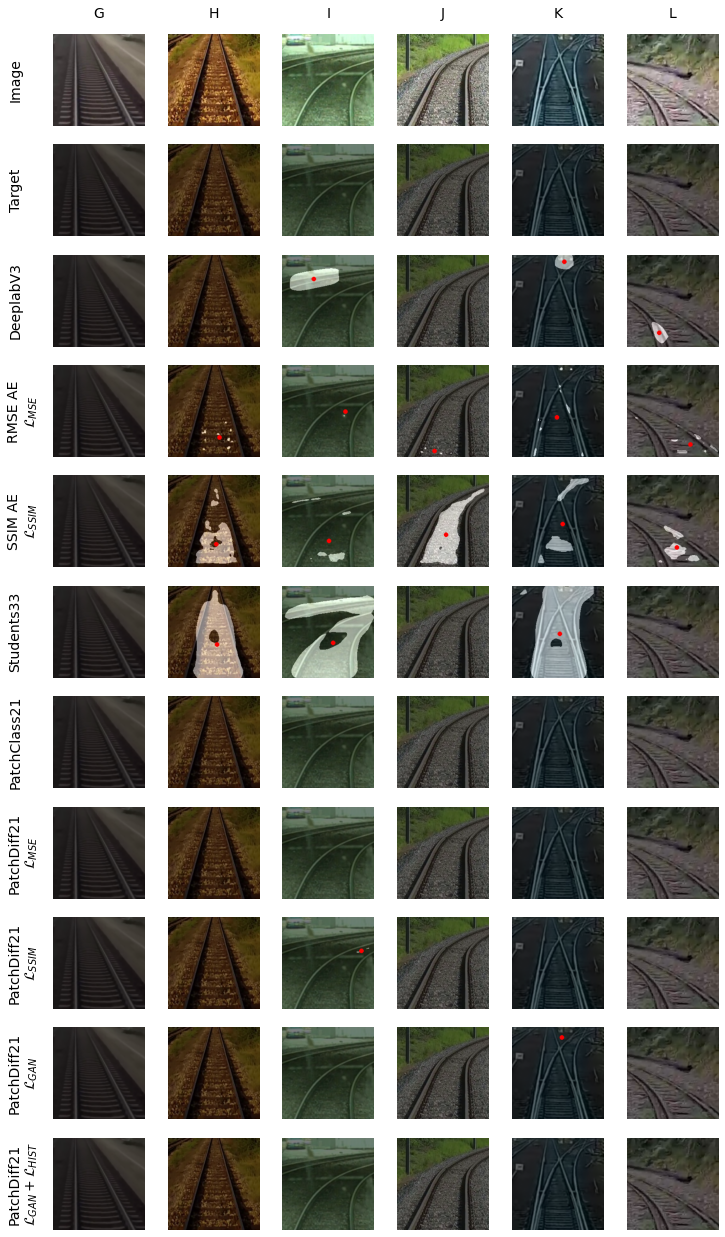

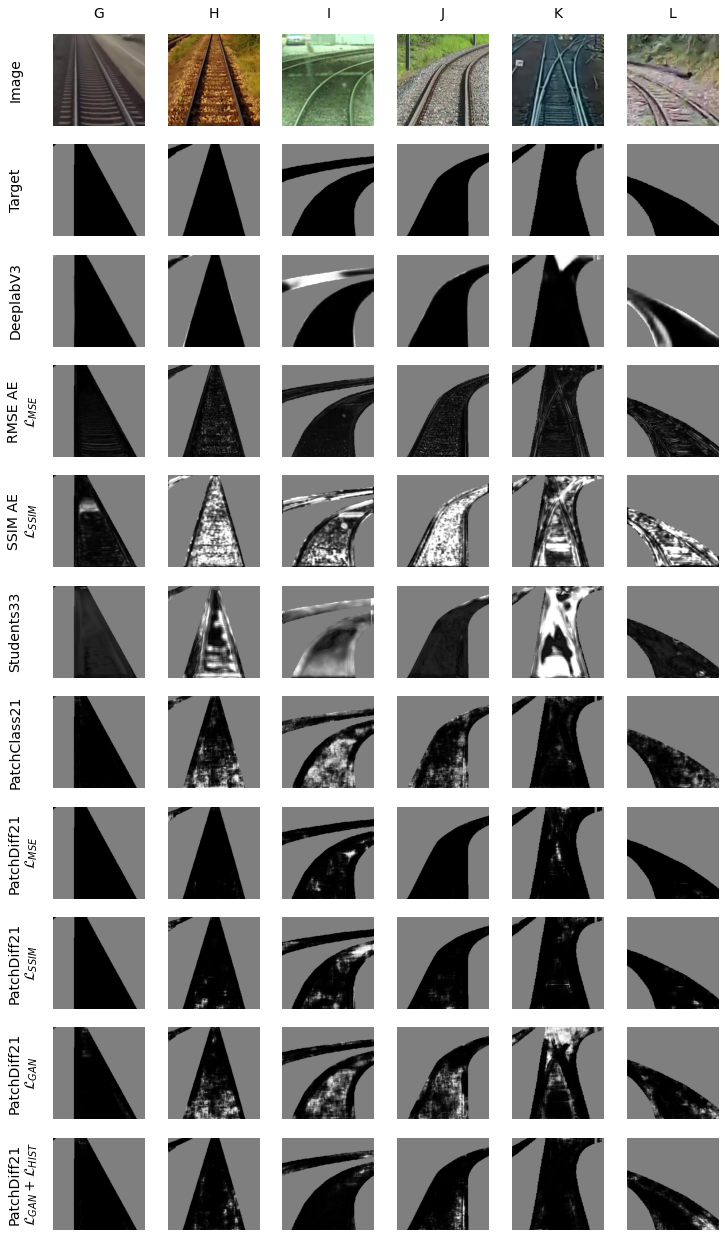

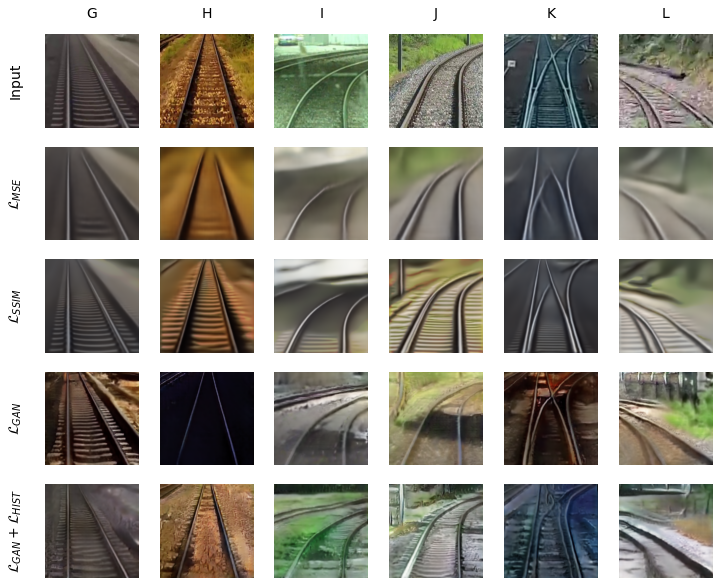

In [23]:
# Visualization Detection

#letters = ['A', 'B', 'C', 'D', 'E', 'F']
letters = ['G', 'H', 'I', 'J', 'K', 'L']

num_rows = len(method_list) + 2
num_cols = len(idx_list)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(2*num_cols,2*num_rows))
plt.axis('off')

# go over columns (images)
for image_idx in range(len(idx_list)):
    # Targets first
    result_m = method_results[0][image_idx]
    image_fishy = result_m[f"image_{mymode}"]
    ax = axes[0, image_idx]
    ax.imshow(image_fishy)
    if image_idx == 0:
        ax.annotate("Image\n", xy=(-0.1, 0.5), xytext=(-20, 0),
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='center', rotation=90)
    ax.annotate(f"{letters[image_idx]}", xy=(0.5, 1), xytext=(0, 20),
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='center')
    #ax.annotate(f"{idx_list[image_idx]}", size=14, xy=(0, 1), ha='left')
    ax.axis('off')
    target_seg_fishy = result_m[f"target_detect_{mymode}"]
    ax = axes[1, image_idx]
    ax.imshow(target_seg_fishy)
    if image_idx == 0:
        ax.annotate("Target\n", xy=(-0.1, 0.5), xytext=(-20, 0),
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='center', rotation=90)
    ax.axis('off')
    

    # go over rows (methods)
    for method_idx in range(len(method_results)):
        result_m = method_results[method_idx][image_idx]
        pred_seg_fishy = result_m[f"pred_detect_{mymode}"]
        ax = axes[method_idx+2, image_idx]
        ax.imshow(pred_seg_fishy)
        if image_idx == 0:
            ax.annotate(method_list[method_idx]["column1"], xy=(-0.1, 0.5), xytext=(-20, 0),
                xycoords='axes fraction', textcoords='offset points', rotation=90,
                size=14, ha='center', va='center')
        ax.axis('off')

plt.savefig(f"./THESIS_VISUALIZATIONS/results_final_det_{mymode}.pdf", bbox_inches='tight')
#plt.show()

# Visualization Difference Map

num_rows = len(method_list) + 2
num_cols = len(idx_list)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(2*num_cols,2*num_rows))
plt.axis('off')

# go over rows (images)
for image_idx in range(len(idx_list)):
    # Targets first
    result_m = method_results[0][image_idx]
    image_fishy = result_m[f"image_{mymode}"]
    ax = axes[0, image_idx]
    ax.imshow(image_fishy)
    if image_idx == 0:
        ax.annotate("Image\n", xy=(-0.1, 0.5), xytext=(-20, 0),
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='center', rotation=90)
    ax.annotate(f"{letters[image_idx]}", xy=(0.5, 1), xytext=(0, 20),
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='center')
    ax.axis('off')
    target_seg_fishy = result_m[f"target_seg_{mymode}"]
    ax = axes[1, image_idx]
    ax.imshow(target_seg_fishy)
    if image_idx == 0:
        ax.annotate("Target\n", xy=(-0.1, 0.5), xytext=(-20, 0),
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='center', rotation=90)
    ax.axis('off')

    # go over rows (methods)
    for method_idx in range(len(method_results)):
        result_m = method_results[method_idx][image_idx]
        pred_seg_fishy = result_m[f"pred_seg_{mymode}"]
        ax = axes[method_idx+2, image_idx]
        ax.imshow(pred_seg_fishy)
        if image_idx == 0:
            ax.annotate(method_list[method_idx]["column1"], xy=(-0.1, 0.5), xytext=(-20, 0),
                xycoords='axes fraction', textcoords='offset points', rotation=90,
                size=14, ha='center', va='center')
        ax.axis('off')


plt.savefig(f"./THESIS_VISUALIZATIONS/results_final_seg_{mymode}.pdf", bbox_inches='tight')
#plt.show()

# Autoencoder Visualization

method_list_subset = method_list[-4:]
method_results_subset = method_results[-4:]

num_rows = len(method_list_subset) + 1
num_cols = len(idx_list)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(2*num_cols,2*num_rows))
plt.axis('off')

# go over rows (images)
for image_idx in range(len(idx_list)):
    # Targets first
    result_m = method_results_subset[0][image_idx]
    image_fishy = result_m[f"image_{mymode}"]
    ax = axes[0, image_idx]
    ax.imshow(image_fishy)
    if image_idx == 0:
        ax.annotate("Input", xy=(-0.1, 0.5), xytext=(-20, 0),
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='center', rotation=90)
    ax.annotate(f"{letters[image_idx]}", xy=(0.5, 1), xytext=(0, 20),
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='center')
    ax.axis('off')

    # go over columns (methods)
    for method_idx in range(len(method_results_subset)):
        result_m = method_results_subset[method_idx][image_idx]
        ae_fishy = result_m[f"ae_{mymode}"]
        ax = axes[method_idx+1, image_idx]
        ax.imshow(ae_fishy)
        if image_idx == 0:
            ax.annotate(method_list_subset[method_idx]["column2"], xy=(-0.1, 0.5), xytext=(-20, 0),
                xycoords='axes fraction', textcoords='offset points', rotation=90,
                size=14, ha='center', va='center')
        ax.axis('off')
        #ae_orig = result_m["ae_orig"]

plt.savefig(f"./THESIS_VISUALIZATIONS/results_final_ae_{mymode}.pdf", bbox_inches='tight')
#plt.show()

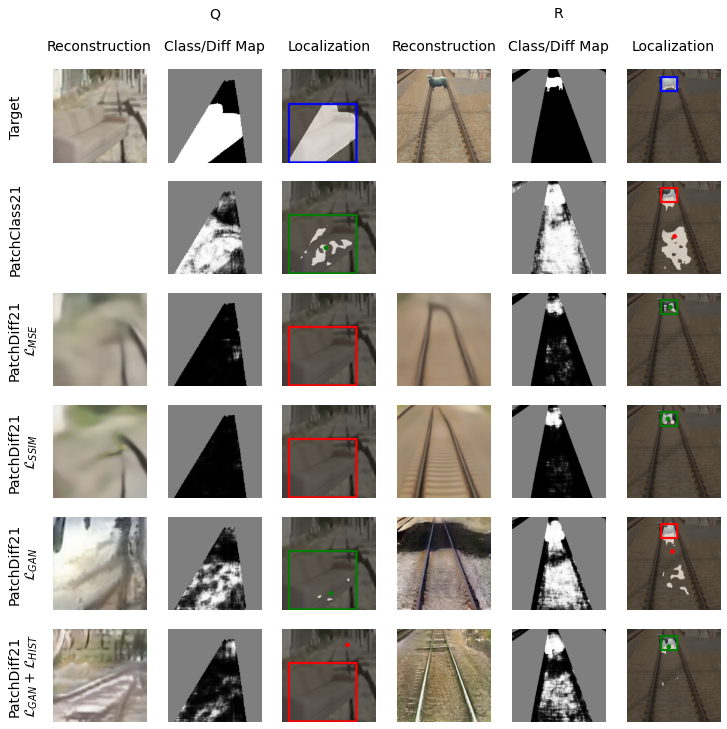

In [11]:
# Bad

letters = ['M', 'N']
letters = ['O', 'P']
letters = ['Q', 'R']
#letters = ['S', 'T']

method_list_subset = method_list[-5:]
method_results_subset = method_results[-5:]

num_rows = len(method_list_subset) + 1
num_cols = 3*len(idx_list)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(2*num_cols,2*num_rows))
plt.axis('off')

# go over columns (images)
for image_idx in range(len(idx_list)):
    # Targets first
    result_m = method_results_subset[0][image_idx]
    image_fishy = result_m[f"image_{mymode}"]
    ax = axes[0, 3*image_idx]
    ax.imshow(image_fishy)
    if image_idx == 0:
        ax.annotate("Target\n", xy=(-0.1, 0.5), xytext=(-20, 0),
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='center', rotation=90)
    ax.annotate(f" \n\nReconstruction", xy=(0.5, 1), xytext=(0, 40),
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='center')
    ax.axis('off')
    target_seg_fishy = result_m[f"target_seg_{mymode}"]
    ax = axes[0, 3*image_idx+1]
    ax.imshow(target_seg_fishy)
    ax.annotate(f"{letters[image_idx]}\n\nClass/Diff Map", xy=(0.5, 1), xytext=(0, 40),
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='center')
    ax.axis('off')
    target_seg_fishy = result_m[f"target_detect_{mymode}"]
    ax = axes[0, 3*image_idx+2]
    ax.imshow(target_seg_fishy)
    ax.annotate(f" \n\nLocalization", xy=(0.5, 1), xytext=(0, 40),
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='center')
    ax.axis('off')
    

    # go over rows (methods)
    for method_idx in range(len(method_results_subset)):
        result_m = method_results_subset[method_idx][image_idx]
        pred_seg_fishy = result_m[f"ae_{mymode}"]
        ax = axes[method_idx+1, 3*image_idx]
        ax.imshow(pred_seg_fishy)
        if image_idx == 0:
            ax.annotate(method_list_subset[method_idx]["column1"], xy=(-0.1, 0.5), xytext=(-20, 0),
                xycoords='axes fraction', textcoords='offset points', rotation=90,
                size=14, ha='center', va='center')
        ax.axis('off')
        pred_seg_fishy = result_m[f"pred_seg_{mymode}"]
        ax = axes[method_idx+1, 3*image_idx+1]
        ax.imshow(pred_seg_fishy)
        ax.axis('off')
        pred_seg_fishy = result_m[f"pred_detect_{mymode}"]
        ax = axes[method_idx+1, 3*image_idx+2]
        ax.imshow(pred_seg_fishy)
        ax.axis('off')

plt.savefig(f"./THESIS_VISUALIZATIONS/results_final_bad_{mymode}_1.pdf", bbox_inches='tight')
#plt.show()


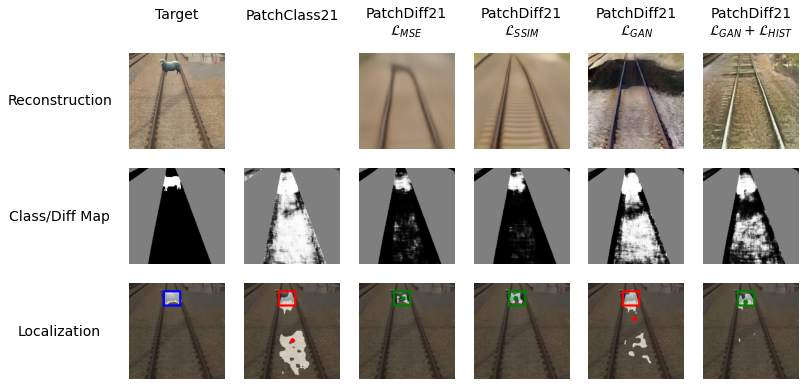

In [13]:
# Bad

idx_list_subset = list()
idx_list_subset.append(idx_list[0])

method_list_subset = method_list[-5:]
method_results_subset = method_results[-5:]

num_rows = len(method_list_subset) + 1
num_cols = 3*len(idx_list_subset)

fig, axes = plt.subplots(num_cols, num_rows, figsize=(2*num_rows,2*num_cols))
plt.axis('off')

# go over columns (images)
for image_idx in range(len(idx_list_subset)):
    # Targets first
    result_m = method_results_subset[0][image_idx+1]
    image_fishy = result_m[f"image_{mymode}"]
    ax = axes[3*image_idx, 0]
    ax.imshow(image_fishy)
    if image_idx == 0:
        ax.annotate("Target\n", xy=(0.5, 1), xytext=(0, 30),
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='center')
    ax.annotate(f"Reconstruction", xy=(-0.1, 0.5), xytext=(-60, 0),
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='center')
    ax.axis('off')
    target_seg_fishy = result_m[f"target_seg_{mymode}"]
    ax = axes[3*image_idx+1, 0]
    ax.imshow(target_seg_fishy)
    ax.annotate(f"Class/Diff Map", xy=(-0.1, 0.5), xytext=(-60, 0),
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='center')
    ax.axis('off')
    target_seg_fishy = result_m[f"target_detect_{mymode}"]
    ax = axes[3*image_idx+2, 0]
    ax.imshow(target_seg_fishy)
    ax.annotate(f"Localization", xy=(-0.1, 0.5), xytext=(-60, 0),
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='center')
    ax.axis('off')
    

    # go over rows (methods)
    for method_idx in range(len(method_results_subset)):
        result_m = method_results_subset[method_idx][image_idx+1]
        pred_seg_fishy = result_m[f"ae_{mymode}"]
        ax = axes[3*image_idx, method_idx+1]
        ax.imshow(pred_seg_fishy)
        if image_idx == 0:
            ax.annotate(method_list_subset[method_idx]["column1"], xy=(0.5, 1), xytext=(0, 30),
                xycoords='axes fraction', textcoords='offset points',
                size=14, ha='center', va='center')
        ax.axis('off')
        pred_seg_fishy = result_m[f"pred_seg_{mymode}"]
        ax = axes[3*image_idx+1, method_idx+1]
        ax.imshow(pred_seg_fishy)
        ax.axis('off')
        pred_seg_fishy = result_m[f"pred_detect_{mymode}"]
        ax = axes[3*image_idx+2, method_idx+1]
        ax.imshow(pred_seg_fishy)
        ax.axis('off')

plt.savefig(f"./THESIS_VISUALIZATIONS/results_presentation_bad_{mymode}_2.pdf", bbox_inches='tight')
#plt.show()